We use the TSP input file from this link and compare the best solution.

https://people.sc.fsu.edu/~jburkardt/datasets/tsp/tsp.html

https://people.sc.fsu.edu/~jburkardt/datasets/cities/cities.html

http://www.math.uwaterloo.ca/tsp/vlsi/index.html

In [31]:
using Pkg
# Pkg.add("Distances")
# Pkg.add("Random")
using Distances
using Random

# diagnostic, parameters choice and impact?

# TODO: improvement report, visualization, other probability formulas
function aco_solution(n, d, min, max_diff, ants, alpha, beta, ip, iterations, Q, es)
    #################################################################
    #####       This part is to initialize some fields         ######
    #################################################################
#     selected tour and ants' tour all start from the first city
    stour = zeros(Int64, n)
    atour = zeros(Int64, ants*n)
    stour[1] = 1
    atour = reshape(atour, ants, n)
    tour_cost = zeros(Float64, ants)
    improve_iteration = 0
#     println(atour[1,:])
    min_d = typemax(Float64)
    
#     pheromone map. N cities has n*(n-1)/2, but we still use n x n to be consistant with d matrix
    pmap = fill(Float64(ip), n*n)
    pmap = reshape(pmap, n, n)
#     probablities to the other cities
    probabilities = zeros(Float64, n)
#     average length of each iteration
    lengths = zeros(Float64, iterations)
    ps = zeros(Float64, iterations)
    shortest_length = zeros(Float64, iterations)

    #################################################################
    #####         This part is to start the iterations         ######
    #################################################################
#     for certain iterations
    for i in 1:(iterations)
        ####################
        ## Edge Selection ##
        ####################
#         Edge selection: each ant starts from the first city finishs its tour
        for ant in 1:ants
#             start from the first city
            current_city = mod(ant, n) + 1
            visited = [current_city]
            length = 0 # length of the tour
#             finish the tour, we need to run n - 1 times because we have n - 1 cities
            for j in 1:(n - 1)
                #########
                ## calculate the probabilities: sum is the denominator
                ########
                sum = 0
#                 calculate the numerators
                for k in 1:n
                    if !in(k, visited)
#                         print(d[current_city, k], ", [", current_city, ", ", k, "]")
                        probabilities[k] = (pmap[current_city, k] ^ alpha) * ((1/d[current_city, k]) ^ beta)
                        sum = sum + probabilities[k]
                    end
                end
#                 println(probabilities)
#                 real probabilities
                next_city = -1 # in case the sum of the probability is 0.99999
                #########
                ## Generate a random number and Select based on probabilities
                #########
                r = rand()
                sum1 = 0
                for k in 1:n
                    probabilities[k] = probabilities[k] / sum
                    sum1 = sum1 + probabilities[k]
                    if r <= sum1
                        next_city = k
                        break
                    end
                end
                #########
                ## Update current status
                #########
                visited = hcat(visited, next_city)
                ps[i] = ps[i] + d[current_city, next_city] / ants 
                length = length + d[current_city, next_city]
                probabilities[next_city] = 0
#                 println("distance = ", d[current_city, next_city])
                current_city = next_city
#             select based on the probabilities and the random number
            end
            # Return the first city
            length = length + d[visited[1], current_city]
            ps[i] = ps[i] + d[visited[1], current_city] / ants 
            # Check if it's better than the global best
            if length < min_d
                min_d = length
                stour = visited
                improve_iteration = i
                println(length, " when iteration = ", i, " and ant ", ant)
                println("selected = ", stour)
                println()
            end
            lengths[i] = min_d
            shortest_length[i] = min_d
            atour[ant, :] = visited
            tour_cost[ant] = length
#             println("visited = ", visited)
#             println(atour)
        end

        ######################
        ## Pheromone Update ##
        ######################
#         evaporate pheromone
        pmap = es * pmap
#         Update the best tour:(Q / minimal_length) pheromone is added to each edge
        for c in 1:(n-1)
            pmap[stour[c], stour[c+1]] = pmap[stour[c], stour[c+1]] + Q/min_d
            pmap[stour[c+1], stour[c]] = pmap[stour[c], stour[c+1]]
        end

#         Update the tours of this iteration: (Q / length^2) pheromone is added to each edge
        for ant in 1:ants
            for c in 1:(n-1)
#                 10% top deposite 70% or only best 3 deposite
                pmap[atour[ant, c], atour[c+1]] = pmap[atour[ant, c], atour[c+1]] + Q/tour_cost[ant]
                pmap[atour[ant, c+1], atour[c]] = pmap[atour[ant, c], atour[c+1]]
            end
        end
#         println("pmap = ", pmap)
        
        #######################
        ## Check Performance ##
        #######################
        if i > min && i - improve_iteration >= max_diff
            println("STOP at iteration ", i, " because no improvement after ",max_iterations_difference, " iterations")
            return (stour, ps, lengths, min_d, i)
        end
    end
    return (stour, ps, lengths, min_d, iterations)
end

# main program
# random generated cities coordinates
# x = rand(2,n) 
# fixed cities coordinates
# x = [0.991189 0.144326 0.902406 0.53709 0.31586 0.887638 0.614103 0.799123 0.0534192 0.879482 0.231045 0.849673 0.49238 0.0877613 0.62428 0.675298 0.389262 0.799248 0.967041 0.115846 0.213548 0.149813 0.339855 0.783606 0.357584 0.0603375 0.11141 0.532691 0.225875 0.963721 0.0894489 0.843015 0.313047 0.37413 0.164087 0.0654062 0.59829 0.629678 0.228623 0.272827 0.956873 0.148458 0.995202 0.274038 0.965106 0.608807 0.128324 0.0748903 0.306886 0.591068; 0.314871 0.993918 0.13529 0.253929 0.875153 0.21286 0.147535 0.494264 0.00387045 0.559584 0.679049 0.370842 0.525374 0.979418 0.609958 0.23424 0.599947 0.365988 0.769707 0.784337 0.129921 0.238884 0.896418 0.296107 0.0867925 0.660012 0.426403 0.353195 0.563629 0.947207 0.263112 0.862994 0.163787 0.547572 0.168269 0.606362 0.893116 0.886913 0.439991 0.414834 0.58367 0.580391 0.564996 0.924946 0.418699 0.119643 0.147008 0.862276 0.72672 0.287891]

# read coordinates file
f = open("tsp131_xy.txt")
lines = readlines(f)
n = 0 # cities
x = []
for l in lines
    s1,s2 = split(l, " ")
    s1=parse(Int64, s1)
    s2=parse(Int64, s2)
    try
        x = hcat(x, [s1, s2])
    catch
        x = [s1, s2]
    end
    n = n+1
end
close(f)

# some modifiable variables
ant_count = 50 # ant number = number of cities
alpha = 0.3 # alpha >= 0
beta = 7 # beta >= 1
iterations = 1000
initial_pheromone = 0.5
pheromone_strength = 0.2
evaporation_speed = 0.6
min_iterations = 200
max_iterations_difference = 300 # stop if no improvement after 200 iterations

# compute Euclidean distance between cities 
d = pairwise(Euclidean(), x, x, dims=2)
# min_aco = []
# min_p
min_length = typemax(Float64)
(aco, performance, bests, length, end_i) =aco_solution(n,d, min_iterations, max_iterations_difference, ant_count, alpha, beta, initial_pheromone, iterations, pheromone_strength, evaporation_speed)
# for i in 1:10
#     (aco, performance, length) =aco_solution(n,d, ant_count, alpha, beta, initial_pheromone, iterations, pheromone_strength, evaporation_speed)
#     if length < min_length
# #         min_aco = aco
# #         min_p = performance
#         min_length = length
#         println("MINI = ", length)
#     end 
# end
println("Tour Length = ", length)

875.1969350389644 when iteration = 1 and ant 1
selected = [2 3 8 7 6 1 12 14 15 16 17 19 27 26 25 18 13 5 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 24 23 10 9 21 20 58 57 56 52 51 50 49 48 47 55 46 54 64 68 75 77 78 82 81 65 62 69 70 66 67 71 76 79 83 84 85 86 80 72 73 59 60 61 63 91 90 95 96 97 104 103 111 117 122 120 116 119 115 110 109 108 107 113 124 125 126 127 128 129 130 123 121 118 114 105 100 101 102 106 112 98 93 99 94 92 87 88 89 45 53 74 22 4 11 131]

846.4736530728907 when iteration = 1 and ant 2
selected = [3 2 8 9 10 4 11 41 42 43 44 24 23 39 38 37 36 35 34 33 32 31 30 29 28 27 26 25 16 17 15 14 6 12 13 18 19 46 45 53 74 89 93 98 100 101 102 106 105 114 118 121 130 123 112 107 113 108 109 115 119 116 120 117 122 129 128 127 126 125 124 99 92 94 87 82 81 78 77 75 68 64 54 55 47 48 49 50 51 52 56 57 63 67 71 76 70 66 65 62 69 79 80 84 85 86 83 95 96 97 103 104 110 111 90 91 61 60 59 73 72 58 22 21 20 7 1 5 40 88 131]

831.1089199220436 when iteration = 1 and ant 3

685.0075219247733 when iteration = 65 and ant 38
selected = [39 40 41 42 43 44 24 23 38 37 36 35 34 33 32 31 30 20 29 28 27 26 19 16 15 14 17 25 18 13 5 12 6 1 7 8 2 3 9 4 10 11 22 21 47 48 49 50 51 52 56 57 58 59 60 61 73 72 67 71 76 70 66 62 65 69 63 80 85 84 86 83 79 81 82 78 77 75 68 64 54 46 45 53 74 89 93 98 101 100 105 102 106 107 108 113 124 125 126 127 128 129 122 117 120 116 115 119 109 110 111 103 104 96 97 95 90 91 88 87 94 92 99 131 114 118 121 130 123 112 55]

682.9009268309579 when iteration = 66 and ant 37
selected = [38 37 36 35 34 33 32 31 30 29 28 27 26 25 19 14 15 16 17 18 13 5 12 6 1 7 8 3 2 9 10 4 11 24 41 42 43 44 40 39 23 22 21 20 47 48 49 50 51 52 56 57 58 59 60 61 73 72 67 71 76 70 66 62 65 69 63 80 85 84 86 83 79 81 82 78 77 75 68 64 54 46 45 53 74 89 93 98 101 100 105 102 106 107 108 113 124 125 126 127 128 129 122 117 120 116 115 119 109 110 111 103 104 96 97 95 90 91 88 87 94 92 99 131 114 118 121 130 123 112 55]

672.8836408467149 when iteration = 67 and 

In [32]:
# read solution
f = open("tsp131_s.txt")
lines = readlines(f)
best = []
for l in lines
    c = parse(Int64, l)
    try
        best = hcat(best, [c])
    catch
        best = [c]
    end
end
close(f)

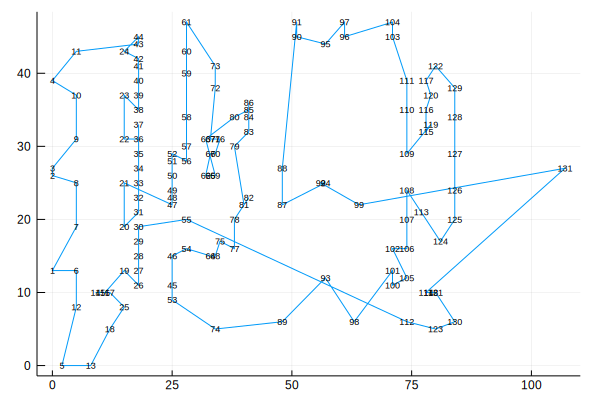

In [33]:
# Pkg.build("Cairo")
# Pkg.add("Luxor")
# using Luxor
# # # draw tsp tour
# function draw_tsp(x,o,n,size=10000,radius=9999)
#     Drawing(size, size, "TSP.png")
#     stretch=Int64(size)
# #     origin(Int64(0.05size),Int64(0.05size))
# #     # draw cities
#     for i in 1:n
#         A=Point(stretch*x[1,i],stretch*x[2,i])
#         circle(A, radius, :fill)
#         label("city $i", :S, A)
#     end
#     # connect cities by edges
#     for i in 1:n-1
#         A=Point(stretch*x[1,o[i]],stretch*x[2,o[i]])
#         B=Point(stretch*x[1,o[i+1]],stretch*x[2,o[i+1]])
#         line(A, B, :stroke)
#     end
#     # return to first city
#     A=Point(stretch*x[1,o[n]],stretch*x[2,o[n]])
#     B=Point(stretch*x[1,o[1]],stretch*x[2,o[1]])
#     line(A, B, :stroke)
#     finish()
#     preview()
# end
# draw_tsp(x,aco,n)
# using Pkg
# Pkg.add("Plots")
using Plots
function draw_aco(twod, aco, cities)
    x = []
    y = []
    ann = []
    for i in 1:cities
        try
            x = vcat(x, twod[1, aco[i]])
            y = vcat(y, twod[2, aco[i]])
            ann = vcat(ann, (twod[1, aco[i]], twod[2, aco[i]],text(aco[i], 6)))
        catch
            x = [twod[1, aco[i]]]
            y = [twod[2, aco[i]]]
            ann = [(twod[1, aco[i]], twod[2, aco[i]], text(aco[i], 6))]
        end
    end
    x = vcat(x, twod[1, aco[1]])
    y = vcat(y, twod[2, aco[1]])
    p1 = plot(x, y, annotations = ann, label = "")
end
draw_aco(x,aco,n)

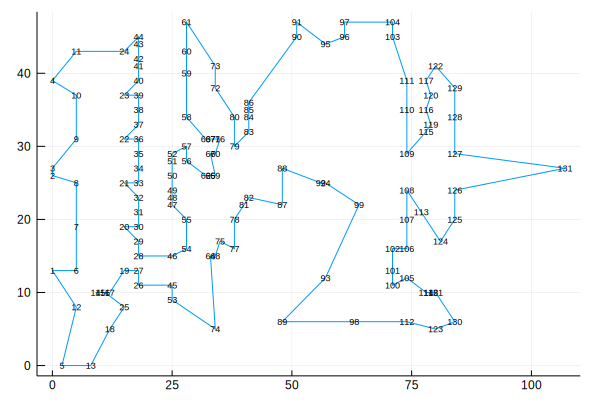

In [30]:
draw_aco(x, best, n)

In [ ]:
## function draw_performance(p, x)
    p1 = plot(1:x, p[1:x])
end
draw_performance(performance, end_i)
# println(end_i)

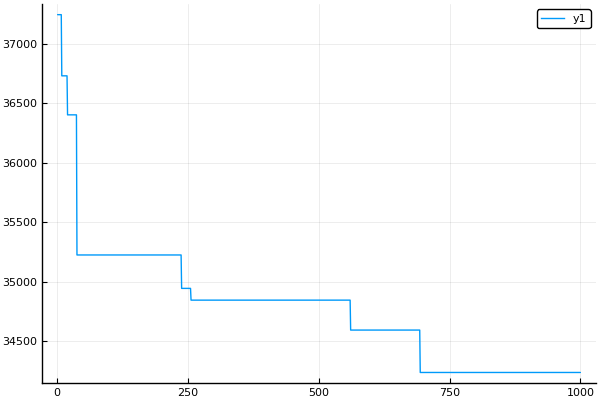

In [301]:
draw_performance(bests, end_i)